# MODEL 3

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from pathlib import Path

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.20.0-rc0


##### SEED DECLARATION

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

##### DATASET PATH

In [4]:
ROOT = Path.cwd()

# Full dataset
# dataset_dir = ROOT / "../data/FullPlantDataset/training"

# Sample dataset
dataset_dir = ROOT / "../data/FullPlantDataset/training_sample"

print(dataset_dir)

C:\Users\Giacomo Da Re\git\Challenges\Challenge1\notebooks\..\data\FullPlantDataset\training_sample


##### DEFINING CLASS NAMES

In [5]:
# Defining class names
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

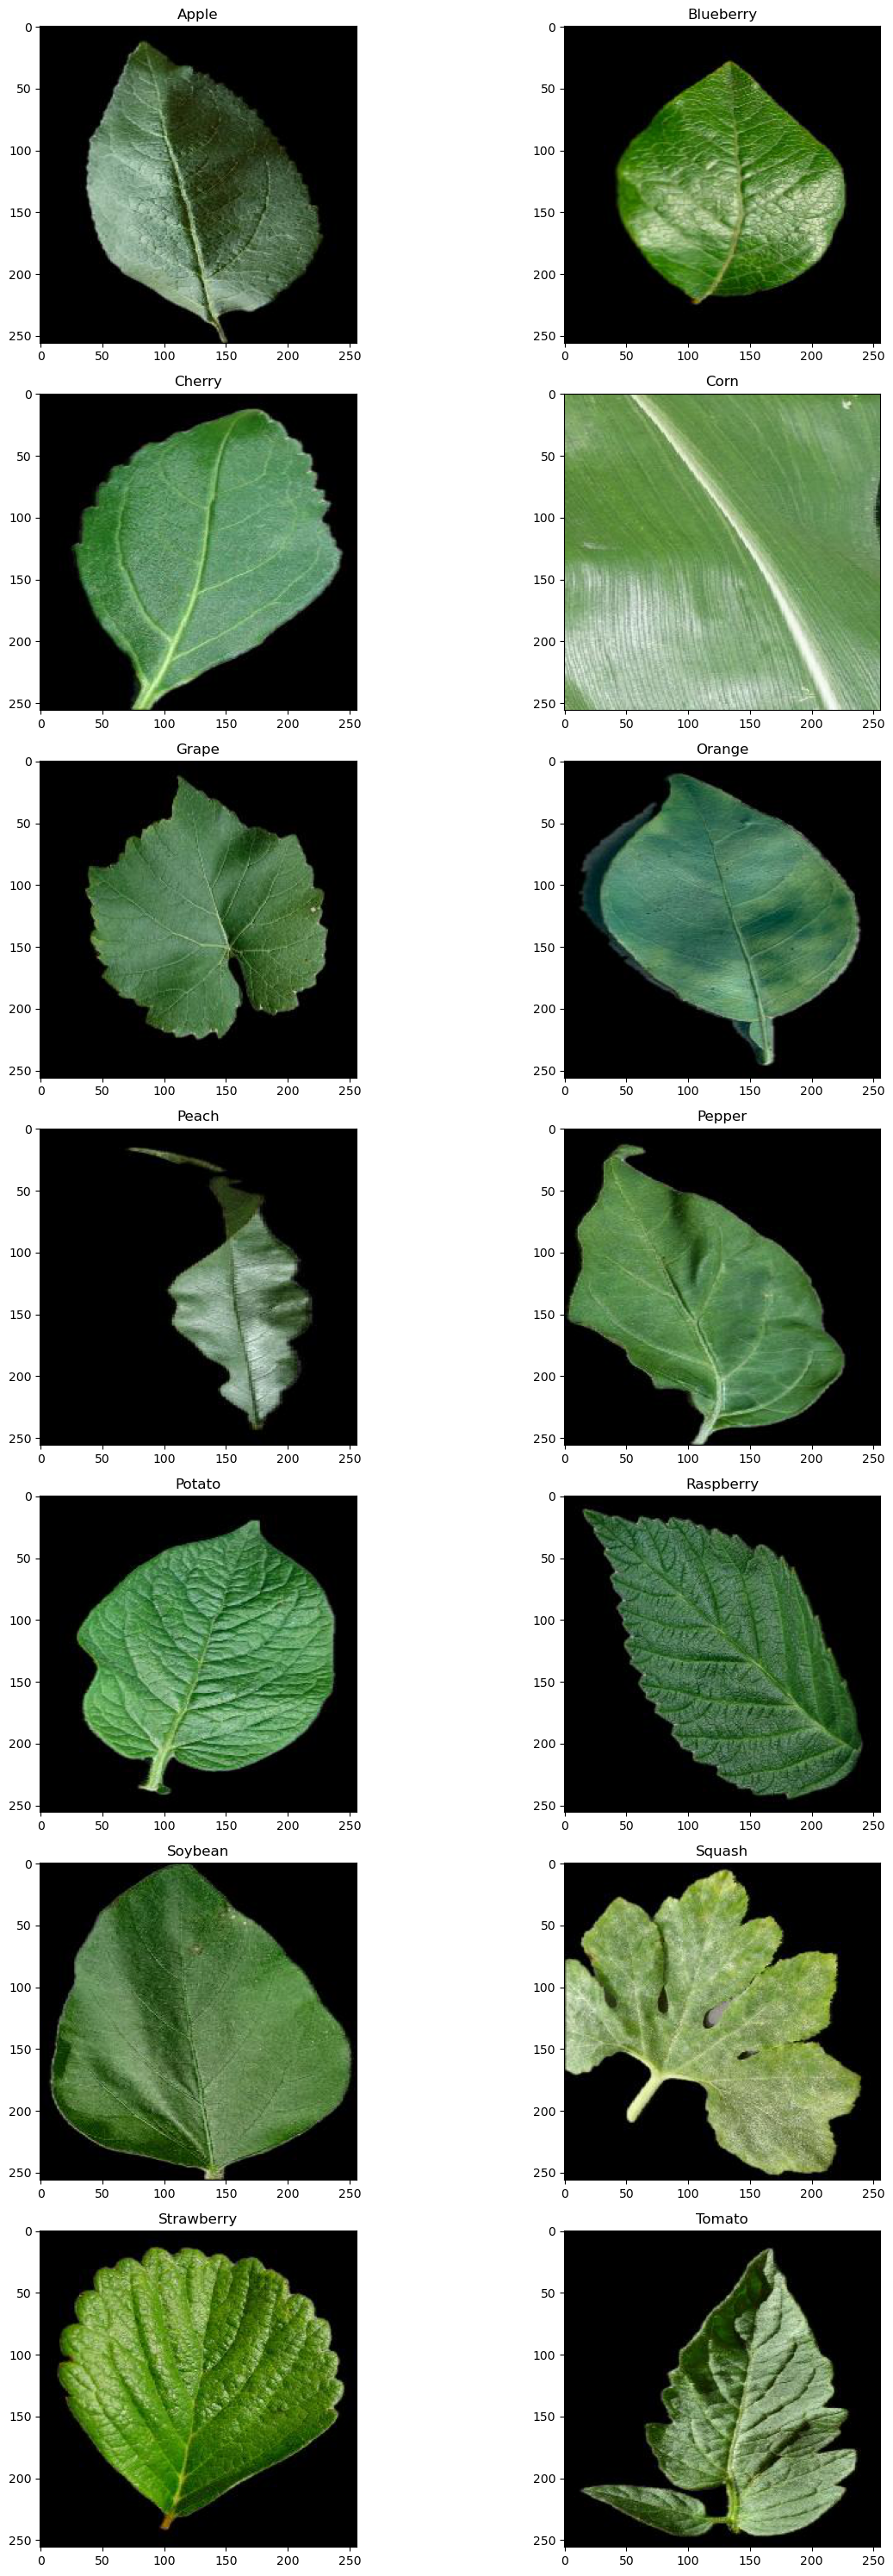

In [6]:
num_row = len(labels) // 2
num_col = len(labels) // num_row

fig, axes = plt.subplots(num_row, num_col, figsize=(2 * num_row, 15 * num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
      
plt.tight_layout()
plt.show()

##### DATA GENERATOR CREATION

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        rescale=1/255,
                                        validation_split=0.3)

In [8]:
train_data_gen = image_generator.flow_from_directory(directory=dataset_dir,
                                                     subset='training')
val_data_gen = image_generator.flow_from_directory(directory=dataset_dir,
                                                   subset='validation')

Found 322 images belonging to 14 classes.
Found 126 images belonging to 14 classes.


In [9]:
print("Assigned labels")
print(train_data_gen.class_indices)
print()
print("Target classes")
print(val_data_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13]


##### PRINT FROM BATCH

(256, 256, 3)


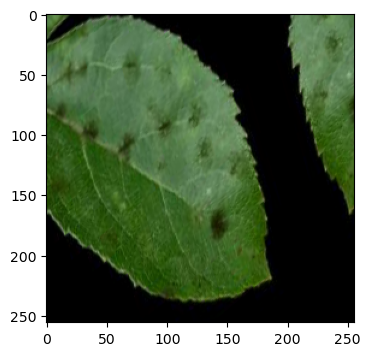

In [10]:
# Get sample batch
batch = next(train_data_gen)[0]

# Get and print first image of the third batch
image = batch[3]

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

# Print input dimension
input_shape = next(train_data_gen)[0].shape[1:]
print(input_shape)

##### CALLBACKS

In [11]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

##### EPOCH DECLARATION

In [12]:
# Originally trained in 50 epochs
# epochs = 50

epochs = 3

##### MODEL DEFINITION

In [13]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    resize_layer = tfkl.Resizing(64, 64, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters = 16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(resize_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters = 32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool4)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)

    classifier_layer = tfkl.Dense(
        units= 256 ,
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer = tfk.regularizers.l2(1e-5),
        name='Classifier')(flattening_layer)
    classifier_layer_f = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(classifier_layer)

    output_layer = tfkl.Dense(
        units=14,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer = tfk.regularizers.l2(1e-5),
        name='Output')(classifier_layer_f)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
model = build_model(input_shape)
model.summary()

##### BATCH SIZE DECLARATION

In [ ]:
batch_size = 32

##### MODEL FIT

In [ ]:
# callbacks = create_folders_and_callbacks(model_name = "Model_less_layer")

# Train the models
standard_history = model.fit(
    x = train_data_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_data_gen,
    # callbacks = callbacks -> ok without sample case
).history

##### OUTPUT GRAPHS

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)